# Accessing the project directory on my Google Drive  

In [2]:
import os
from google.colab import drive

drive.mount('/drive', force_remount=False)
project_dir = "/drive/My Drive/RNNSeq2Seq/"

# change working directory to project_dir
os.chdir(project_dir)

Mounted at /drive


# Dependencies

In [3]:
from scripts.model import *
from scripts.dataloader import create_dataloader
from scripts.utils import *
from scripts.pytorch_utils import *
import matplotlib.pyplot as plt

# Helper function to help visualize 

In [4]:
def plot_log(log):
    len_range = len(log) -1 if "Best eval accu" in log else len(log)
    epoch_nums, train_loss, dev_loss = [], [], []
    train_acc, dev_acc = [], []

    for epoch in range(1, len_range+1):
        epoch_nums.append(epoch)
        train = log[f"Epoch#{epoch}"]["Train"]
        dev = log[f"Epoch#{epoch}"]["Eval"]
        train_loss.append(train['loss'])
        train_acc.append(train['abosulate accuracy'])

        dev_loss.append(dev['loss'])
        dev_acc.append(dev['abosulate accuracy'])

    ax1 = plt.subplot(211)
    ax1.plot(epoch_nums, train_loss, label="train loss")
    ax1.plot(epoch_nums, dev_loss, label="dev loss")
    ax1.legend()

    ax2 = plt.subplot(212)
    ax2.plot(epoch_nums, train_acc, label="train acc")
    ax2.plot(epoch_nums, dev_acc, label="dev acc")
    ax2.legend()
    plt.show()

In [5]:
folder = "tuning_data/"
experiment_num = 4
shuffle_batch = True

# must be the num of seq per seq length if shuffle_batch is False
# this "tr_batch_size" will be used for dev, and shuffled test sets
tr_batch_size = 250 
dev_batch_size = 500 if not shuffle_batch else tr_batch_size

In [6]:
# setups for training and evaluting

print_freq = 5
acc_threshold = 0.5 # for saving the best trained models 
max_epoch_num = 150 # max num of epoches 
train_acc_exit=0.9999 # train acc exit threshold (eval_acc_exit must also be met)
eval_acc_exit=0.995 # dev acc exit threshold (train_acc_exit must also be met)
teacher_forcing_ratio = 1.0 # probability of using real symbol from target sequence for training

# RevStr

In [7]:
train = read_data(join(folder, "RevStr/train.txt"))
dev = read_data(join(folder, "RevStr/dev.txt"))
saved_model_fp = join(project_dir, "notebooks/Hyperparatemers Tuning/RevStr_rnn_model.pt")

train_dl = create_dataloader(train, batch_size=tr_batch_size, shuffle=shuffle_batch)
dev_dl = create_dataloader(dev, batch_size=dev_batch_size, shuffle=shuffle_batch)

## Hyperparameter set 1


In [8]:
in_vocab = ascii_lowercase
out_vocab = ascii_lowercase
in_vocab_size = len(in_vocab) + 2
out_vocab_size = len(out_vocab) + 2

hidden_size = 256
embd_dim = 128
num_layers = 1
rnn_type = "RNN"
dropout_rate = 0.0
bidirectional = False
use_attention = True
reduction_method = torch.sum

learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [9]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 1.9366239488124848, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0007316666866245214, 'overlap rate': 0.4348250448703766}
evaluation performance: {'loss': 2.0864994913339614, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0007301130095584085, 'overlap rate': 0.4330095238983631}

Current epoch: 10, 
training performance: {'loss': 1.9060091912746429, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0008033333542698529, 'overlap rate': 0.44266670718789103}
evaluation performance: {'loss': 2.0231525525450706, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0007800000195857138, 'overlap rate': 0.4379308793693781}

Current epoch: 15, 
training performance: {'loss': 1.8849996864795684, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.000808333361055702, 'overlap rate': 0.4478750430047512}
evaluation performance: {'loss': 1.9572402700781821, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.

KeyboardInterrupt: ignored

## Hyperparameter set 2

In [10]:
hidden_size = 256
embd_dim = 128
num_layers = 1
rnn_type = "RNN"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 1.911244186758995, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0008483333520416636, 'overlap rate': 0.44272337555885316}
evaluation performance: {'loss': 2.8202838391065597, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0008291666821605759, 'overlap rate': 0.44147754497826097}

Current epoch: 10, 
training performance: {'loss': 1.7919133096933364, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0015766666838317178, 'overlap rate': 0.4725883848965168}
evaluation performance: {'loss': 2.5302709698677064, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0025229237464373, 'overlap rate': 0.453220397233963}

Current epoch: 15, 
training performance: {'loss': 1.5583952456712722, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.007613333407789469, 'overlap rate': 0.529753378033638}
evaluation performance: {'loss': 1.9909508138895036, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.00864

KeyboardInterrupt: ignored

# RedStr



In [12]:
train = read_data(join(folder, "RedStr/train.txt"))
dev = read_data(join(folder, "RedStr/dev.txt"))
saved_model_fp = join(project_dir, "notebooks/Hyperparatemers Tuning/RevStr_model.pt")

train_dl = create_dataloader(train, batch_size=tr_batch_size, shuffle=shuffle_batch)
dev_dl = create_dataloader(dev, batch_size=dev_batch_size, shuffle=shuffle_batch)

## Hyperparameter set 1


In [13]:
hidden_size = 256
embd_dim = 128
num_layers = 1
rnn_type = "RNN"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 1.8999735981225967, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0016583333577727898, 'overlap rate': 0.4478600464761257}
evaluation performance: {'loss': 2.096175955235958, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0017066666958271525, 'overlap rate': 0.4490775477141142}

Current epoch: 10, 
training performance: {'loss': 1.4440693646669387, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.007645000074990094, 'overlap rate': 0.5657783895730972}
evaluation performance: {'loss': 1.5178821310400963, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.010120833473047241, 'overlap rate': 0.5448833912611007}

Current epoch: 15, 
training performance: {'loss': 0.30759371183812617, 'abosulate accuracy': 0.14470000695437193, 'consecutive overlap rate': 0.2910516712814569, 'overlap rate': 0.9401567488908767}
evaluation performance: {'loss': 0.44958693012595174, 'abosulate accuracy': 0.27390001248568296, 'c

KeyboardInterrupt: ignored

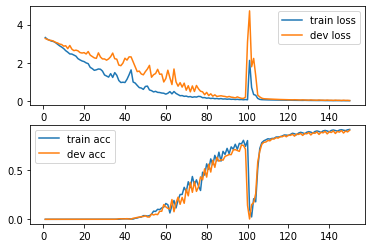

In [ ]:
plot_log(log)